## ptCLM_NEON
#### Plots simulated vs. observed ratiation, energy fluxes & GPP at tower sites
- Will Wieder
- Created Sept 20, 2020

In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
from ctsm_py import utils
from scipy import signal,stats

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Point to files

In [2]:
network = 'NEON'

if network == 'NEON':
    # NEON data
    site  = 'KONZ'
    longSite =  site
    # need to determine rollHour, to get local noon for diel plots
    rollHour = -12  #UNDE = -11, KONZ=-12,  ABBY=-15 , HARV=-9 

    case  = 'clm50bgcNEON_'+site
    years = range(2018,2020)
    nmon  = 12
    OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NEON/'+site+'/'
    OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
    OUTdir = OBSdir
    #print(OBSfile)

if network == 'Niwot':
    # Niwot LTER  simulations
    site  = 'dm'
    longSite  =  'dry_meadow'
    rollHour = -12  
    case  = 'clm50bgc_NWT_'+site
    years = range(2008,2018)
    nmon  = 12
    OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
    OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
    OUTdir = OBSdir
    #print(OBSfile)


CLMdir = '/glade/scratch/wwieder/archive/'+case+'/lnd/hist/'
CLMfile = [CLMdir + case +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' for i in range(len(years)) ]  
CLMmon = CLMdir + case +'.clm2.h0.'+str(years[1])+'-01.nc' # single month of data for soil C pools 
CLMfile[0]

'/glade/scratch/wwieder/archive/clm50bgcNEON_KONZ/lnd/hist/clm50bgcNEON_KONZ.clm2.h1.2018-01-01-00000.nc'

### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [3]:
dsOBS = utils.time_set_mid(xr.open_mfdataset(OBSfile, decode_times=True, 
                                             combine='by_coords'), 'time')
dsCLM = xr.open_mfdataset(CLMfile, decode_times=True, combine='by_coords')
dsCLMmon = xr.open_mfdataset(CLMmon, decode_times=True, combine='by_coords')

dsOBS = dsOBS.isel(lat=0, lon=0)
dsCLM = dsCLM.isel(lndgrid=0)
dsCLMmon = dsCLMmon.isel(lndgrid=0, time=0)
dsCLM = dsCLM.shift(time=-1)
print('---- read  in data  ----')

---- read  in data  ----


In [4]:
# create new variables to subset data
print(dsCLMmon.SOILC_vr)
dsOBS['year']  = dsOBS['time.year']
dsOBS['month']  = dsOBS['time.month']
dsCLM['year']  = dsCLM['time.year']
dsCLM['month']  = dsCLM['time.month']
dsOBS['season'] = dsOBS['time.season']
dsCLM['season'] = dsCLM['time.season']
#Can't groupby hour & minutes, so combine them here
dsOBS['HourMin'] = np.round(dsOBS['time.hour'] + dsOBS['time.minute']/60,1)
dsCLM['HourMin'] = np.round(dsCLM['time.hour'] + dsCLM['time.minute']/60,1)
dsOBS['MonDay'] = np.round(dsOBS['time.month'] + dsOBS['time.day']/100,2)
dsCLM['MonDay'] = np.round(dsCLM['time.month'] + dsCLM['time.day']/100,2)

# calculate Rnet from absorbed - reflected radiation
dsCLM['Rnet'] = dsCLM.FSA - dsCLM.FIRA	
dsCLM['Rnet'].attrs['units'] = dsCLM.FSA.attrs['units']
dsCLM['Rnet'].attrs['long_name'] = 'net radiation'

#  total preciptiation
dsCLM['ppt'] = dsCLM.RAIN + dsCLM.SNOW
dsCLM['ppt'].attrs['units'] = dsCLM.RAIN.attrs['units']
dsCLM['ppt'].attrs['long_name'] = 'RAIN + SNOW'

<xarray.DataArray 'SOILC_vr' (levsoi: 20)>
dask.array<getitem, shape=(20,), dtype=float32, chunksize=(20,)>
Coordinates:
    time     object 2019-02-01 00:00:00
Dimensions without coordinates: levsoi
Attributes:
    long_name:     SOIL C (vertically resolved)
    units:         gC/m^3
    cell_methods:  time: mean


In [5]:
# convert obs GPP units from umol/m2/s to g/m2/h
# assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600
dsOBS['GPP'].attrs['units'] = 'gC/m2/h'
# convert clm GPP units from g/m2/s to g/m2/h
dsCLM['GPP'] = dsCLM.GPP * 3600
dsCLM['GPP'].attrs['units'] = 'gC/m2/h'

### Plots of seasonal data

In [6]:
Var = ['Rnet','FSH','EFLX_LH_TOT','GPP']
Season = ['DJF','MAM','JJA','SON']

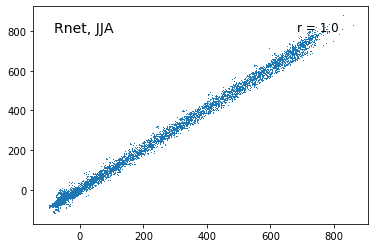

In [7]:
# First make a test for one season and variable
fig, ax = plt.subplots()
x, y = dsOBS[Var[0]].where(dsOBS.season==Season[2]).values,  \
    dsCLM[Var[0]].where(dsCLM.season==Season[2]).values

ax.plot(x, y,',')
line = mlines.Line2D([x.min(), x.max()], [x.min(), x.max()], color='k')
ax.add_line(line)
ax.text(0.15, 0.90,(Var[0]+', '+Season[2]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, 
        ha='center', va='center', transform=plt.gca().transAxes);

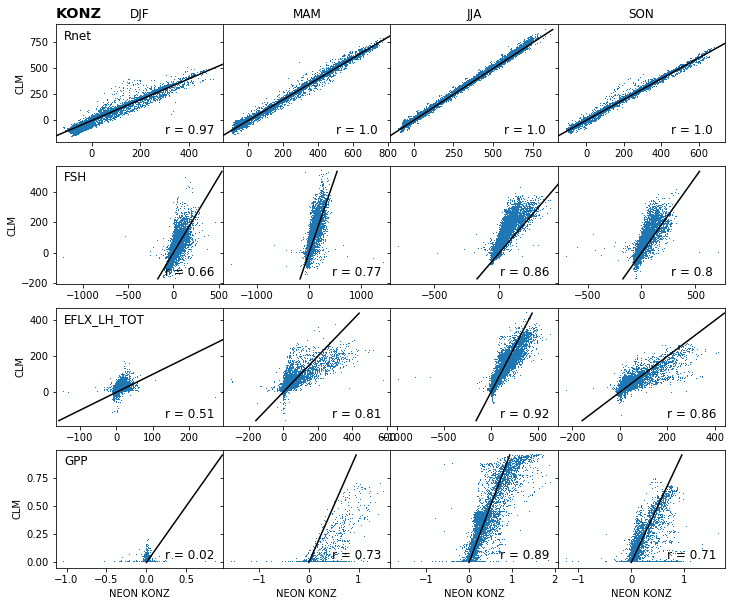

In [8]:
fig, axs = plt.subplots(len(Season), len(Var), sharey='row', #sharey='col',
                        gridspec_kw={'wspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    ymin = dsCLM[Var[v]].min()
    ymax = dsCLM[Var[v]].max()
    for i in range(len(Season)):
        x = dsOBS[Var[v]].where(dsOBS.season==Season[i]).values
        y = dsCLM[Var[v]].where(dsCLM.season==Season[i]).values
        axs[v,i].plot(x, y,',')
        line = mlines.Line2D([ymin, ymax], [ymin, ymax], color='k')
        axs[v,i].add_line(line)

        # add stats
        bad = ~np.logical_or(np.isnan(x), np.isnan(y))
        x = np.compress(bad, x)  
        y = np.compress(bad, y) 
        R, p = stats.pearsonr(x,y)
        R = np.round(R, 2)
        axs[v,i].text(0.8, 0.1,'r = '+str(R),fontsize=12, 
                     ha='center', va='center', transform=axs[v,i].transAxes)

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            #axs[v,i].text(0.15, 0.90,(Season[i]), fontsize=12, ha='center', va='center', 
            #    transform=axs[v,i].transAxes)
            if i == 0:
                axs[i, v].set_title(site, loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel(network+' '+longSite)
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel('CLM')
            axs[v,i].text(0.05, 0.90,(Var[v]), fontsize=12, ha='left', va='center', 
                transform=axs[v,i].transAxes)

plt.savefig(OUTdir+site+'_FluxScatter.pdf');

## Diel cycle

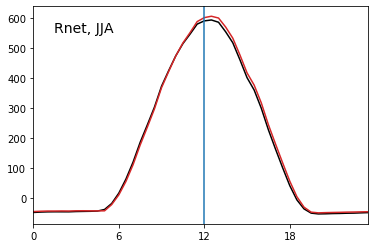

In [9]:
# quick look at one season, variable
v, i = 0, 2
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
#ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
#ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);
ax.axvline(x=12)
plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0));

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support 'N' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support 'E' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support 'O' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


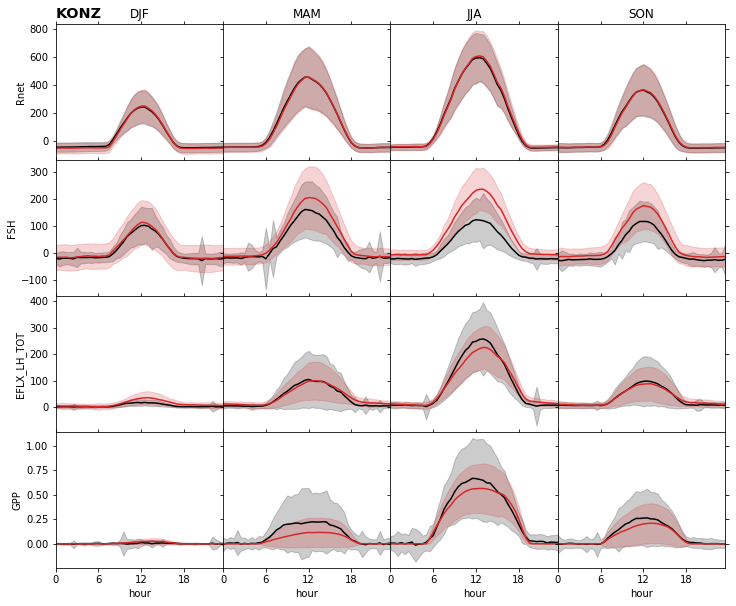

In [10]:
# This is really slow, not sure why.
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    xmin = dsOBS[Var[v]].min()
    xmax = dsOBS[Var[v]].max()
    for i in range(len(Season)):
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend((network+' '+longSite),'CLM5', frameon=False)
                axs[v,i].set_title(site, loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 

plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0))

plt.savefig(OUTdir+site+'_FluxDiel.pdf');

### Plot mean annual cycle

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Legend does not support 'N' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Legend does not support 'E' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Legend does not support 'O' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


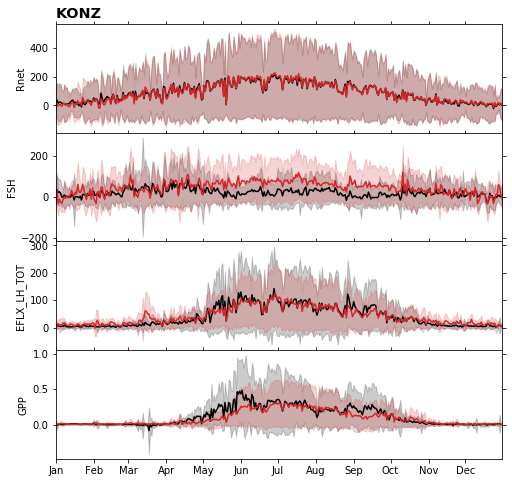

In [11]:
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(len(Var),1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(8,8))
for v in range(len(Var)):
    # using groupby('time.dayofyear') gives too many days in leap year
    # use variable MonDay  instead
    x = dsOBS['time'].groupby(dsOBS.MonDay).min()
    obsX = dsOBS[Var[v]].groupby(dsOBS.MonDay).mean()
    clmX = dsCLM[Var[v]].groupby(dsOBS.MonDay).mean()
    obsSD = dsOBS[Var[v]].groupby(dsOBS.MonDay).std()
    clmSD = dsCLM[Var[v]].groupby(dsOBS.MonDay).std()
        
    axs[v].plot(x, obsX, '-', color='k')
    axs[v].fill_between(x, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
    axs[v].plot(x, clmX, '-',color='tab:red')
    axs[v].fill_between(x, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
    axs[v].set_ylabel(Var[v])       
    axs[v].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
    axs[v].xaxis.set_ticks_position('both')     

    # set  x axis limits
    axs[v].format_xdata = mdates.DateFormatter('%Y-%m-%d')
    axs[v].xaxis.set_major_locator(months)
    axs[v].xaxis.set_major_formatter(months_fmt)
    datemin = np.datetime64(x[0].values, 'm')
    datemax = np.datetime64(x[-1].values, 'm') 
    axs[v].set_xlim(datemin, datemax)

    # control titles & axis labels
    if v == 0: 
        axs[v].set_title(site, loc='left', fontsize='x-large', fontweight='bold')
        axs[v].legend((network+' '+longSite),'CLM5', frameon=False)

#fig.autofmt_xdate()
plt.savefig(OUTdir+site+'_FluxAnnual.pdf');

## plot depth-time plots of soil moisture and temperature

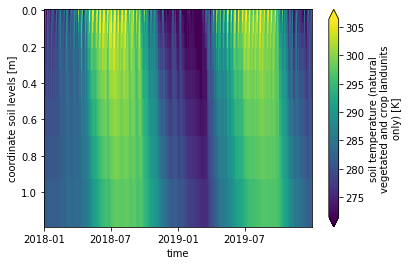

In [12]:
dsCLM.TSOI.isel(levgrnd=(slice(0,9))).plot(x="time",yincrease=False, robust=True);

In [13]:
dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values

array([0.01, 0.04, 0.09, 0.16, 0.26, 0.4 , 0.58, 0.8 , 1.06, 1.36, 1.7 ,
       2.08, 2.5 , 2.99, 3.58, 4.27, 5.06, 5.95, 6.94, 8.03],
      dtype=float32)

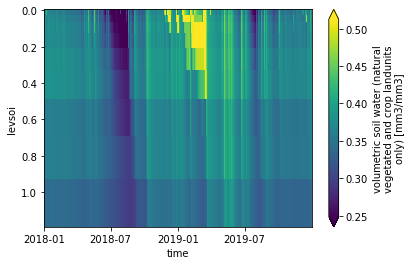

In [14]:
temp = dsCLM['H2OSOI'].copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
#dsCLM.H2OSOI.levsoi  =  dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values
temp.isel(levsoi=(slice(0,9))).plot(x="time",yincrease=False, robust=True);

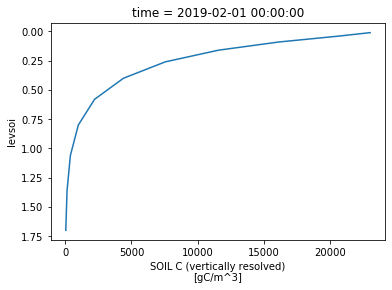

In [15]:
temp = dsCLMmon.SOILC_vr.copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
temp.isel(levsoi=(slice(0,11))).plot(y='levsoi',yincrease=False);


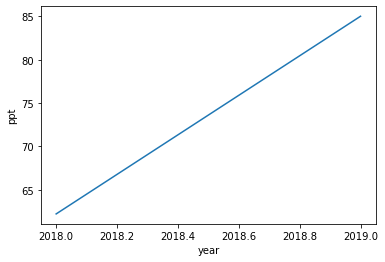

In [16]:
annPPT = dsCLM['ppt'].groupby(dsCLM['year']).mean()
annPPT = annPPT * 3600 * 24 * 365 / 10  #convert mm/s to cm/y
annPPT.plot();


### look into sources of potential flux errors

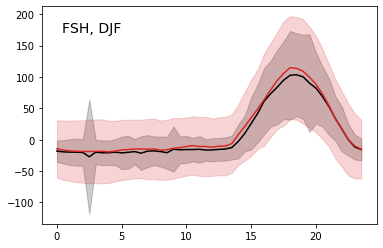

In [17]:
Var = ['FSH','TBOT','FSDS','FLDS']
v = 0
i = 0
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean()
clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean()#.roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std()
clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std()#.roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

In [ ]:
# This is really slow, not sure why.
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    for i in range(len(Season)):
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        if Var[v]!='TBOT':
            clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
            clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        else:
            clmX = dsCLM['TG'].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
            clmSD = dsCLM['TG'].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

            
        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend((network+' '+longSite),'CLM5', frameon=False)
                axs[v,i].set_title(site, loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 'N' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 'E' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Legend does not support 'O' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
